# S&P500 Forecasting with Machine Learning
<h4>Blake Rayvid - <a href=https://github.com/brayvid>https://github.com/brayvid</a></h4>


# Download S&P500 (^GSPC) price history

In [ ]:
import yfinance as yf

In [ ]:
data = yf.Ticker("^GSPC").history(period="max")
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-08-02 00:00:00-04:00,5376.629883,5383.890137,5302.029785,5346.560059,5156450000,0.0,0.0
2024-08-05 00:00:00-04:00,5151.140137,5250.890137,5119.259766,5186.330078,5333250000,0.0,0.0
2024-08-06 00:00:00-04:00,5206.419922,5312.339844,5193.560059,5240.029785,4690190000,0.0,0.0


<Axes: xlabel='Date'>

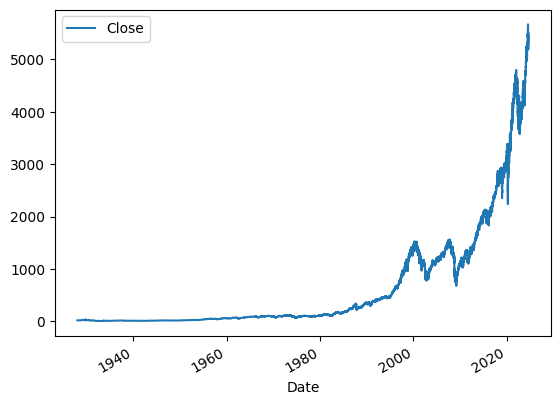

In [ ]:
data.plot.line(y="Close",use_index=True)

# Preprocessing

In [ ]:
data.drop(labels=['Dividends','Stock Splits'], axis=1,inplace=True)

In [ ]:
data['Tomorrow'] = data['Close'].shift(-1)

In [ ]:
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)

In [ ]:
data = data.loc['1990-01-01':].copy()

# Toy model - Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=42)

In [ ]:
train = data.iloc[:-100]
test = data.iloc[-100:]

In [ ]:
predictors = ['Close','Volume','Open','High','Low']

In [ ]:
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=42)

In [ ]:
from sklearn.metrics import precision_score
import pandas as pd

In [ ]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [ ]:
precision_score(test['Target'], preds)

0.5384615384615384

In [ ]:
combined = pd.concat([test['Target'], preds], axis=1)

<Axes: xlabel='Date'>

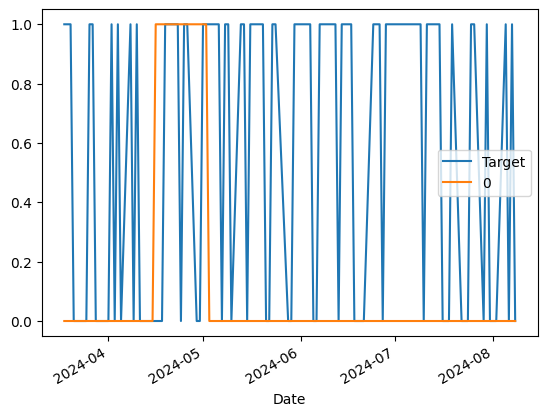

In [ ]:
combined.plot()

# Backtesting paradigm

In [ ]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = pd.Series(model.predict(test[predictors]), index=test.index, name="Predictions")
  combined = pd.concat([test['Target'], preds], axis=1)
  return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions)

In [ ]:
predictions = backtest(data, model, predictors)

In [ ]:
predictions['Predictions'].value_counts()

,count
Predictions,
0,3502
1,2715


In [ ]:
precision_score(predictions['Target'],predictions['Predictions'])

0.5307550644567219

In [ ]:
predictions['Target'].value_counts() / predictions.shape[0]

,count
Target,
1,0.535146
0,0.464854


# Including derived features

In [ ]:
horizons = [2, 5, 60, 250, 1000]

new_predictors = []

for horizon in horizons:
  rolling_averages = data.rolling(horizon).mean()
  ratio_column = f'Close_Ratio_{horizon}'
  data[ratio_column] = data['Close'] / rolling_averages['Close']
  trend_column = f'Trend_{horizon}'
  data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
  new_predictors += [ratio_column, trend_column]

new_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000']

In [ ]:
data = data.dropna()

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=42)

In [ ]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= 0.6] = 1
  preds[preds < 0.6] = 0
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test['Target'], preds], axis=1)
  return combined

In [ ]:
predictions = backtest(data, model, new_predictors)

In [ ]:
predictions['Predictions'].value_counts()

,count
Predictions,
0.0,4419
1.0,797


In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5746549560853199

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, ConfusionMatrixDisplay

In [ ]:
roc_auc_score(predictions['Target'],predictions['Predictions'])

0.5091785748375405

In [ ]:
accuracy_score(predictions['Target'],predictions['Predictions'])

0.47795245398773006

In [ ]:
recall_score(predictions['Target'],predictions['Predictions'])

0.16115411681914146

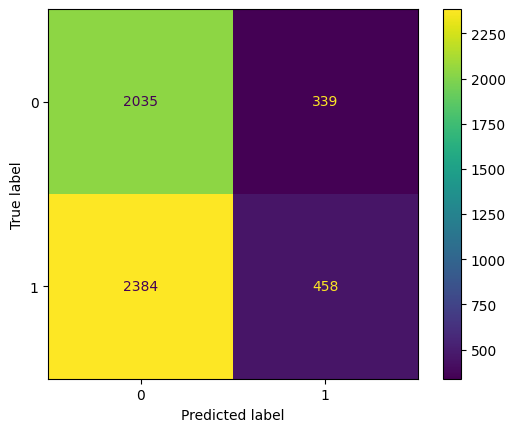

In [ ]:
ConfusionMatrixDisplay.from_predictions(predictions['Target'],predictions['Predictions'])

# Gradient Boosting Classifier

## Incorporate basic economic data

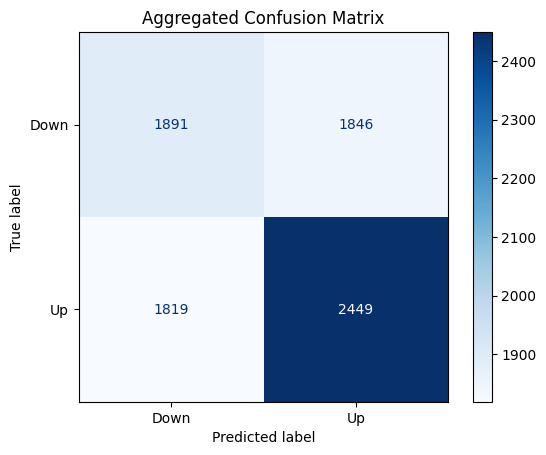

              precision    recall  f1-score      support
0.0            0.509704  0.506021  0.507856  3737.000000
1.0            0.570198  0.573805  0.571996  4268.000000
accuracy       0.542161  0.542161  0.542161     0.542161
macro avg      0.539951  0.539913  0.539926  8005.000000
weighted avg   0.541957  0.542161  0.542053  8005.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic data from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims'
}

fred_data = {}
for indicator, name in indicators.items():
    fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
    # Convert FRED data index to be timezone-naive
    fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)

# Merge FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs and new derived features
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + new_predictors

# Prepare the dataset
X = data[predictors]
y = data['Target']

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
model = GradientBoostingClassifier(random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


## Incorporate more economic data and technical indicators $^{*}$

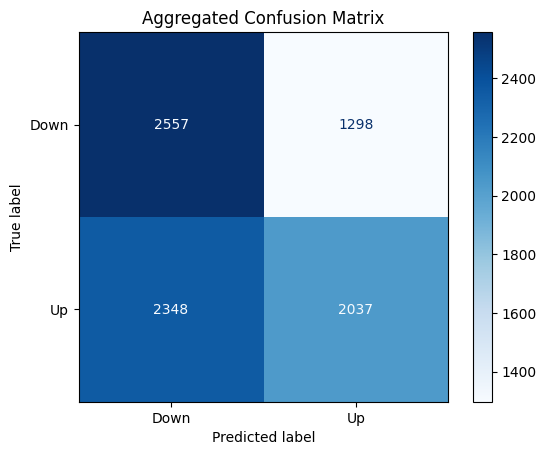

              precision    recall  f1-score      support
0.0            0.521305  0.663294  0.583790  3855.000000
1.0            0.610795  0.464538  0.527720  4385.000000
accuracy       0.557524  0.557524  0.557524     0.557524
macro avg      0.566050  0.563916  0.555755  8240.000000
weighted avg   0.568928  0.557524  0.553952  8240.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic and market data from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims',
    'DGS10': '10-Year Treasury Yield',
    'FEDFUNDS': 'Federal Funds Rate',
    'BAA10Y': 'Baa Corporate Bond Yield Spread',
    'VIXCLS': 'VIX Index',
    'DCOILWTICO': 'Crude Oil Prices',
    'UMCSENT': 'Consumer Confidence Index',
    'RSXFS': 'Retail Sales',
    'HOUST': 'Housing Starts',
    'INDPRO': 'Industrial Production Index'
}

fred_data = {}
for indicator, name in indicators.items():
    try:
        fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
        # Convert FRED data index to be timezone-naive
        fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)
    except Exception as e:
        print(f"Could not fetch data for {name} ({indicator}): {e}")

# Merge available FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Technical indicators
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
data['RSI_14'] = 100 - (100 / (1 + data['Close'].diff().rolling(window=14).apply(lambda x: (x[x>0].sum()) / (-x[x<0].sum()), raw=True)))
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['Bollinger_High'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
data['Bollinger_Low'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs, new derived features, and technical indicators
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + new_predictors + [
    'SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'RSI_14', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low'
]

# Prepare the dataset
X = data[predictors]
y = data['Target']

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
model = GradientBoostingClassifier(random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


### Feature importances

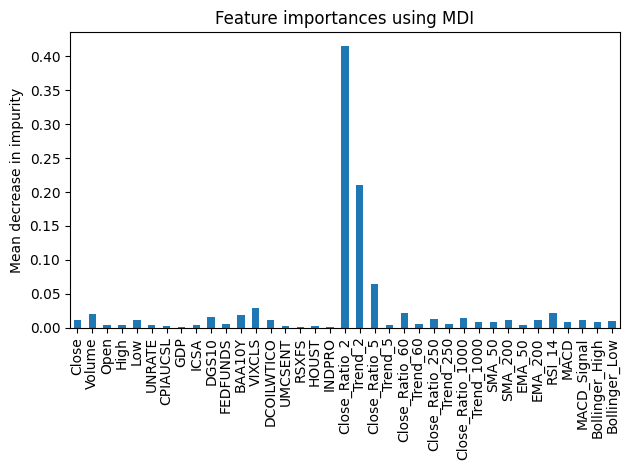

In [ ]:
importances = model.feature_importances_
importances = pd.Series(importances, index=predictors)

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Standard scale all features

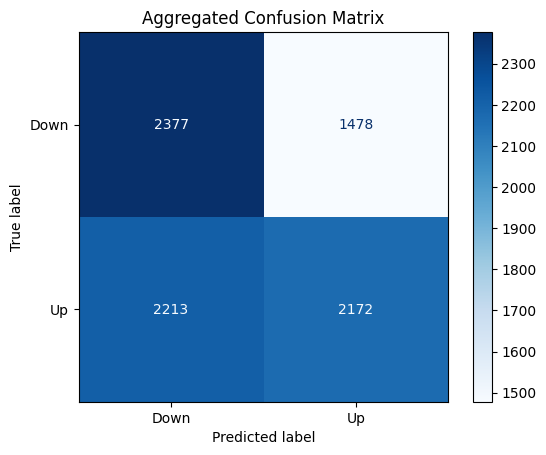

              precision    recall  f1-score      support
0.0            0.517865  0.616602  0.562937  3855.000000
1.0            0.595068  0.495325  0.540635  4385.000000
accuracy       0.552063  0.552063  0.552063     0.552063
macro avg      0.556467  0.555963  0.551786  8240.000000
weighted avg   0.558950  0.552063  0.551068  8240.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic and market data from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims',
    'DGS10': '10-Year Treasury Yield',
    'FEDFUNDS': 'Federal Funds Rate',
    'BAA10Y': 'Baa Corporate Bond Yield Spread',
    'VIXCLS': 'VIX Index',
    'DCOILWTICO': 'Crude Oil Prices',
    'UMCSENT': 'Consumer Confidence Index',
    'RSXFS': 'Retail Sales',
    'HOUST': 'Housing Starts',
    'INDPRO': 'Industrial Production Index'
}

fred_data = {}
for indicator, name in indicators.items():
    try:
        fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
        # Convert FRED data index to be timezone-naive
        fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)
    except Exception as e:
        print(f"Could not fetch data for {name} ({indicator}): {e}")

# Merge available FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Technical indicators
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
data['RSI_14'] = 100 - (100 / (1 + data['Close'].diff().rolling(window=14).apply(lambda x: (x[x>0].sum()) / (-x[x<0].sum()), raw=True)))
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['Bollinger_High'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
data['Bollinger_Low'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs, new derived features, and technical indicators
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + new_predictors + [
    'SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'RSI_14', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low'
]

# Prepare the dataset
X = data[predictors]
y = data['Target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
model = GradientBoostingClassifier(random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


### Feature importances

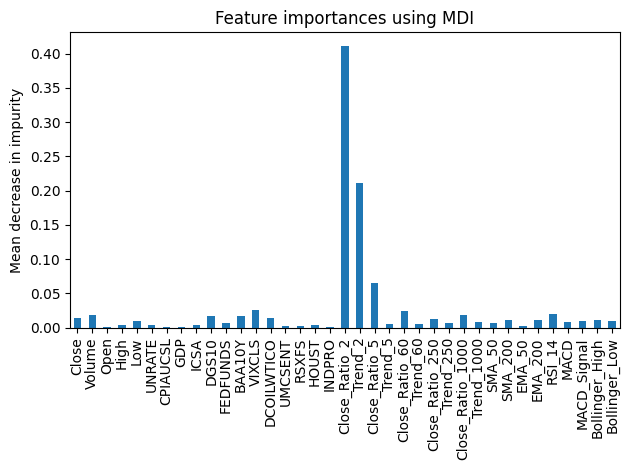

In [ ]:
importances = model.feature_importances_
importances = pd.Series(importances, index=predictors)

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Random Forest Classifier

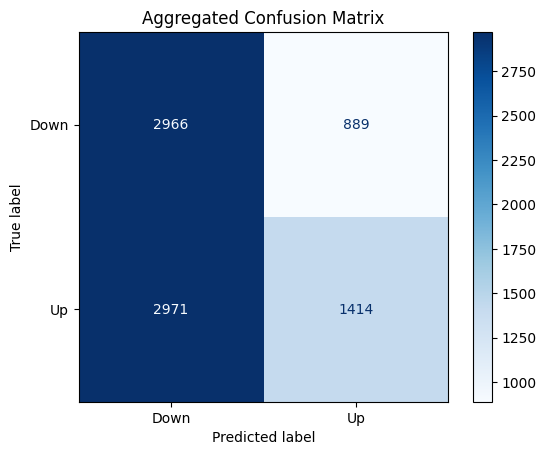

              precision    recall  f1-score      support
0.0            0.499579  0.769390  0.605801  3855.000000
1.0            0.613982  0.322463  0.422847  4385.000000
accuracy       0.531553  0.531553  0.531553     0.531553
macro avg      0.556780  0.545927  0.514324  8240.000000
weighted avg   0.560460  0.531553  0.508440  8240.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic and market data from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims',
    'DGS10': '10-Year Treasury Yield',
    'FEDFUNDS': 'Federal Funds Rate',
    'BAA10Y': 'Baa Corporate Bond Yield Spread',
    'VIXCLS': 'VIX Index',
    'DCOILWTICO': 'Crude Oil Prices',
    'UMCSENT': 'Consumer Confidence Index',
    'RSXFS': 'Retail Sales',
    'HOUST': 'Housing Starts',
    'INDPRO': 'Industrial Production Index'
}

fred_data = {}
for indicator, name in indicators.items():
    try:
        fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
        # Convert FRED data index to be timezone-naive
        fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)
    except Exception as e:
        print(f"Could not fetch data for {name} ({indicator}): {e}")

# Merge available FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Technical indicators
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
data['RSI_14'] = 100 - (100 / (1 + data['Close'].diff().rolling(window=14).apply(lambda x: (x[x>0].sum()) / (-x[x<0].sum()), raw=True)))
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['Bollinger_High'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
data['Bollinger_Low'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs, new derived features, and technical indicators
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + new_predictors + [
    'SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'RSI_14', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low'
]

# Prepare the dataset
X = data[predictors]
y = data['Target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


## Weekly predictions, all features

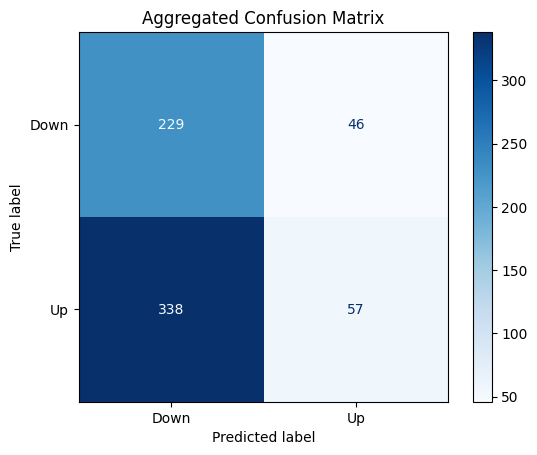

              precision    recall  f1-score     support
0              0.403880  0.832727  0.543943  275.000000
1              0.553398  0.144304  0.228916  395.000000
accuracy       0.426866  0.426866  0.426866    0.426866
macro avg      0.478639  0.488516  0.386429  670.000000
weighted avg   0.492029  0.426866  0.358218  670.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history and resample to weekly frequency
data = yf.Ticker("^GSPC").history(period="max").resample('W').last()

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic and market data from FRED and resample to weekly frequency
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims',
    'DGS10': '10-Year Treasury Yield',
    'FEDFUNDS': 'Federal Funds Rate',
    'BAA10Y': 'Baa Corporate Bond Yield Spread',
    'VIXCLS': 'VIX Index',
    'DCOILWTICO': 'Crude Oil Prices',
    'UMCSENT': 'Consumer Confidence Index',
    'RSXFS': 'Retail Sales',
    'HOUST': 'Housing Starts',
    'INDPRO': 'Industrial Production Index'
}

fred_data = {}
for indicator, name in indicators.items():
    try:
        fred_data[indicator] = web.DataReader(indicator, 'fred', start, end).resample('W').last()
        # Convert FRED data index to be timezone-naive
        fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)
    except Exception as e:
        print(f"Could not fetch data for {name} ({indicator}): {e}")

# Merge available FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]  # These horizons will now represent weeks
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Technical indicators
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
data['RSI_14'] = 100 - (100 / (1 + data['Close'].diff().rolling(window=14).apply(lambda x: (x[x>0].sum()) / (-x[x<0].sum()), raw=True)))
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['Bollinger_High'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
data['Bollinger_Low'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs, new derived features, and technical indicators
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + new_predictors + [
    'SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'RSI_14', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low'
]

# Prepare the dataset
X = data[predictors]
y = data['Target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


## Weekly, no derived features, fewer economic indicators

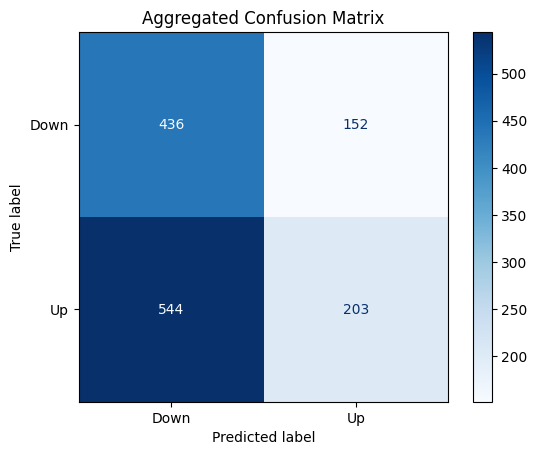

              precision    recall  f1-score      support
0              0.444898  0.741497  0.556122   588.000000
1              0.571831  0.271754  0.368421   747.000000
accuracy       0.478652  0.478652  0.478652     0.478652
macro avg      0.508364  0.506625  0.462272  1335.000000
weighted avg   0.515923  0.478652  0.451094  1335.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history and resample to weekly frequency
data = yf.Ticker("^GSPC").history(period="max").resample('W').last()

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching a conservative selection of economic and market data from FRED and resample to weekly frequency
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'DGS10': '10-Year Treasury Yield'
}

fred_data = {}
for indicator, name in indicators.items():
    try:
        fred_data[indicator] = web.DataReader(indicator, 'fred', start, end).resample('W').last()
        # Convert FRED data index to be timezone-naive
        fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)
    except Exception as e:
        print(f"Could not fetch data for {name} ({indicator}): {e}")

# Merge available FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate a conservative selection of derived features
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['RSI_14'] = 100 - (100 / (1 + data['Close'].diff().rolling(window=14).apply(lambda x: (x[x>0].sum()) / (-x[x<0].sum()), raw=True)))

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) conservatively
predictors = ['Close', 'Volume', 'SMA_50', 'SMA_200', 'RSI_14'] + list(fred_data.keys())

# Prepare the dataset
X = data[predictors]
y = data['Target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


## Weekly, fewer features, no standard scaling

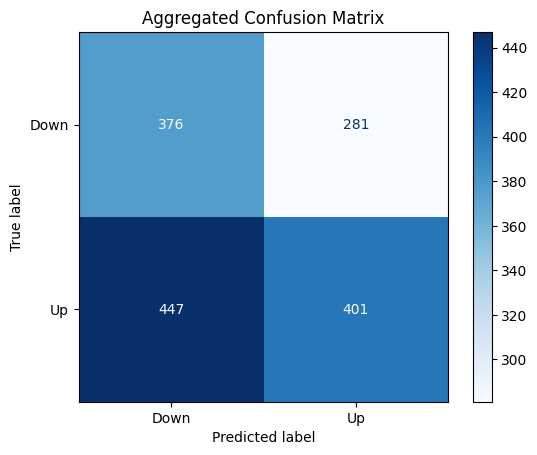

              precision    recall  f1-score      support
0              0.456865  0.572298  0.508108   657.000000
1              0.587977  0.472877  0.524183   848.000000
accuracy       0.516279  0.516279  0.516279     0.516279
macro avg      0.522421  0.522588  0.516146  1505.000000
weighted avg   0.530741  0.516279  0.517166  1505.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history and resample to weekly frequency
data = yf.Ticker("^GSPC").history(period="max").resample('W').last()

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching a conservative selection of economic and market data from FRED and resample to weekly frequency
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'DGS10': '10-Year Treasury Yield',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims'
}

fred_data = {}
for indicator, name in indicators.items():
    try:
        fred_data[indicator] = web.DataReader(indicator, 'fred', start, end).resample('W').last()
        # Convert FRED data index to be timezone-naive
        fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)
    except Exception as e:
        print(f"Could not fetch data for {name} ({indicator}): {e}")

# Merge available FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Define the predictors (features) conservatively
predictors = ['Close', 'Volume'] + list(fred_data.keys())

# Prepare the dataset
X = data[predictors]
y = data['Target']

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


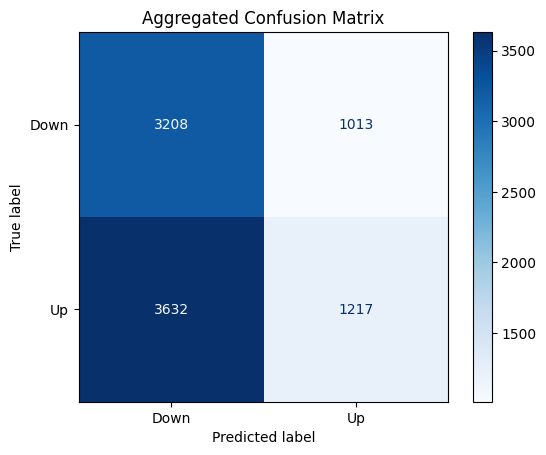

              precision    recall  f1-score      support
0.0            0.469006  0.760009  0.580056  4221.000000
1.0            0.545740  0.250980  0.343834  4849.000000
accuracy       0.487872  0.487872  0.487872     0.487872
macro avg      0.507373  0.505495  0.461945  9070.000000
weighted avg   0.510029  0.487872  0.453767  9070.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic indicators from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'DGS10': '10-Year Treasury Yield',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims'
}

fred_data = {}
for indicator, name in indicators.items():
    try:
        fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
        # Convert FRED data index to be timezone-naive
        fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)
    except Exception as e:
        print(f"Could not fetch data for {name} ({indicator}): {e}")

# Merge available FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) conservatively
predictors = ['Close', 'Volume'] + list(fred_data.keys())

# Prepare the dataset
X = data[predictors]
y = data['Target']

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


# Back to GradientBoostingClassifier

## Standard scale, fewer features

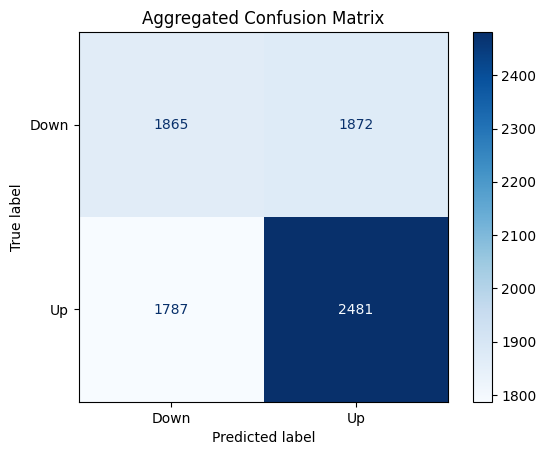

              precision    recall  f1-score      support
0.0            0.510679  0.499063  0.504804  3737.000000
1.0            0.569952  0.581303  0.575571  4268.000000
accuracy       0.542911  0.542911  0.542911     0.542911
macro avg      0.540315  0.540183  0.540188  8005.000000
weighted avg   0.542281  0.542911  0.542535  8005.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic data from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims'
}

fred_data = {}
for indicator, name in indicators.items():
    fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
    # Convert FRED data index to be timezone-naive
    fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)

# Merge FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs and new derived features
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + new_predictors

# Prepare the dataset
X = data[predictors]
y = data['Target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
model = GradientBoostingClassifier(random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


## No standard scaling ⭐️

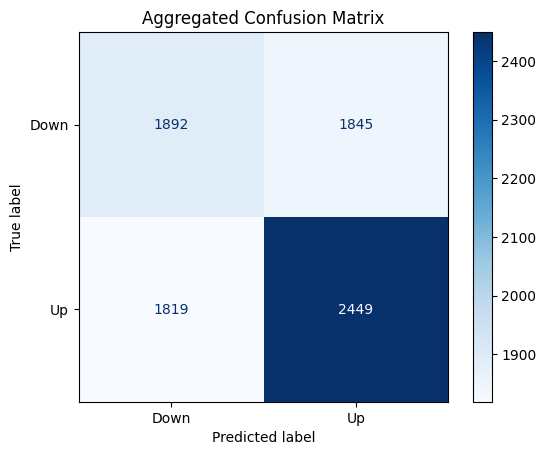

              precision    recall  f1-score      support
0.0            0.509836  0.506288  0.508056  3737.000000
1.0            0.570331  0.573805  0.572063  4268.000000
accuracy       0.542286  0.542286  0.542286     0.542286
macro avg      0.540083  0.540047  0.540059  8005.000000
weighted avg   0.542090  0.542286  0.542182  8005.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic data from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims'
}

fred_data = {}
for indicator, name in indicators.items():
    fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
    # Convert FRED data index to be timezone-naive
    fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)

# Merge FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs and new derived features
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + new_predictors

# Prepare the dataset
X = data[predictors]
y = data['Target']

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
model = GradientBoostingClassifier(random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


### Feature importances

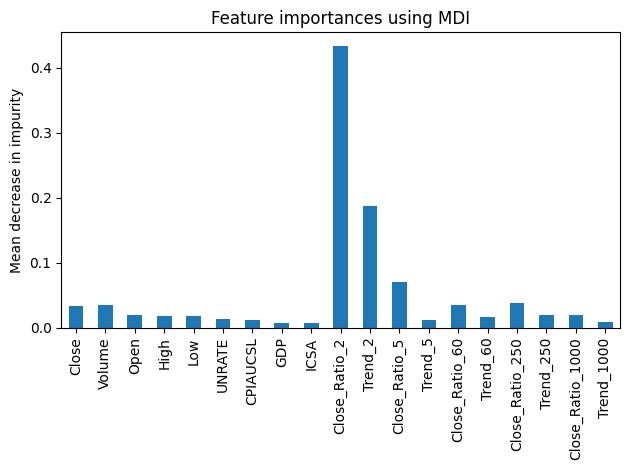

In [ ]:
importances = model.feature_importances_
importances = pd.Series(importances, index=predictors)

fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Notes
- GradientBoostingClassifier working better than RandomForestClassifier
- No noticeable difference with normalization or not. (57% recall for 'up' class)

# Try neural network

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


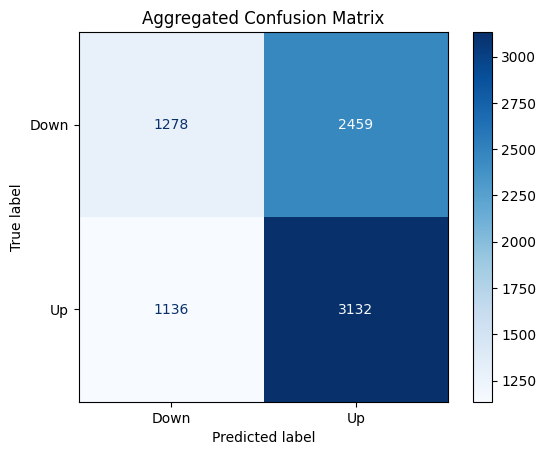

              precision    recall  f1-score      support
0.0            0.529412  0.341986  0.415542  3737.000000
1.0            0.560186  0.733833  0.635359  4268.000000
accuracy       0.550906  0.550906  0.550906     0.550906
macro avg      0.544799  0.537909  0.525450  8005.000000
weighted avg   0.545820  0.550906  0.532741  8005.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic data from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims'
}

fred_data = {}
for indicator, name in indicators.items():
    fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
    # Convert FRED data index to be timezone-naive
    fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)

# Merge FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs and new derived features
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + new_predictors

# Prepare the dataset
X = data[predictors]
y = data['Target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the neural network model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


## Neural network with all features

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


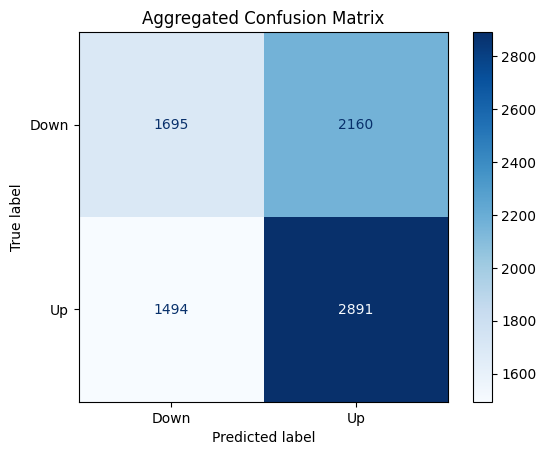

              precision    recall  f1-score      support
0.0            0.531515  0.439689  0.481261  3855.000000
1.0            0.572362  0.659293  0.612760  4385.000000
accuracy       0.556553  0.556553  0.556553     0.556553
macro avg      0.551938  0.549491  0.547010  8240.000000
weighted avg   0.553252  0.556553  0.551239  8240.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic indicators from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims',
    'DGS10': '10-Year Treasury Yield',
    'FEDFUNDS': 'Federal Funds Rate',
    'BAA10Y': 'Baa Corporate Bond Yield Spread',
    'VIXCLS': 'VIX Index',
    'DCOILWTICO': 'Crude Oil Prices',
    'UMCSENT': 'Consumer Confidence Index',
    'RSXFS': 'Retail Sales',
    'HOUST': 'Housing Starts',
    'INDPRO': 'Industrial Production Index'
}

fred_data = {}
for indicator, name in indicators.items():
    fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
    # Convert FRED data index to be timezone-naive
    fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)

# Merge FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate technical indicators
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
data['RSI_14'] = 100 - (100 / (1 + data['Close'].diff().rolling(window=14).apply(lambda x: (x[x > 0].sum()) / (-x[x < 0].sum()), raw=True)))
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['Bollinger_High'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
data['Bollinger_Low'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs, new derived features, and technical indicators
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + [
    'SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'RSI_14', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low'
] + new_predictors

# Prepare the dataset
X = data[predictors]
y = data['Target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the neural network model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


## Deeper network ⭐️

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


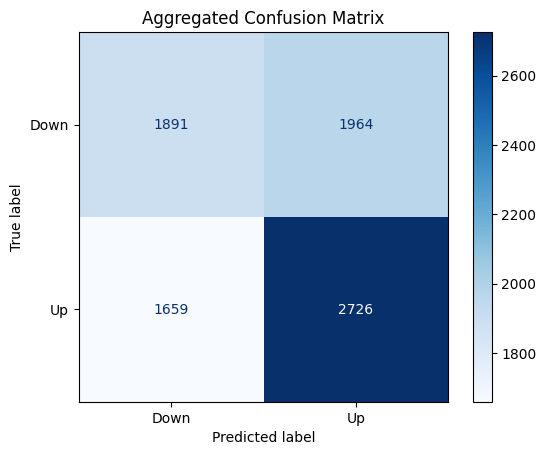

              precision    recall  f1-score      support
0.0            0.532676  0.490532  0.510736  3855.000000
1.0            0.581237  0.621665  0.600771  4385.000000
accuracy       0.560316  0.560316  0.560316     0.560316
macro avg      0.556956  0.556098  0.555754  8240.000000
weighted avg   0.558518  0.560316  0.558649  8240.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic indicators from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims',
    'DGS10': '10-Year Treasury Yield',
    'FEDFUNDS': 'Federal Funds Rate',
    'BAA10Y': 'Baa Corporate Bond Yield Spread',
    'VIXCLS': 'VIX Index',
    'DCOILWTICO': 'Crude Oil Prices',
    'UMCSENT': 'Consumer Confidence Index',
    'RSXFS': 'Retail Sales',
    'HOUST': 'Housing Starts',
    'INDPRO': 'Industrial Production Index'
}

fred_data = {}
for indicator, name in indicators.items():
    fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
    # Convert FRED data index to be timezone-naive
    fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)

# Merge FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate technical indicators
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
data['RSI_14'] = 100 - (100 / (1 + data['Close'].diff().rolling(window=14).apply(lambda x: (x[x > 0].sum()) / (-x[x < 0].sum()), raw=True)))
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['Bollinger_High'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
data['Bollinger_Low'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs, new derived features, and technical indicators
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + [
    'SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'RSI_14', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low'
] + new_predictors

# Prepare the dataset
X = data[predictors]
y = data['Target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the deeper neural network model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

    # Predict
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


## Incorporate engineered features

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


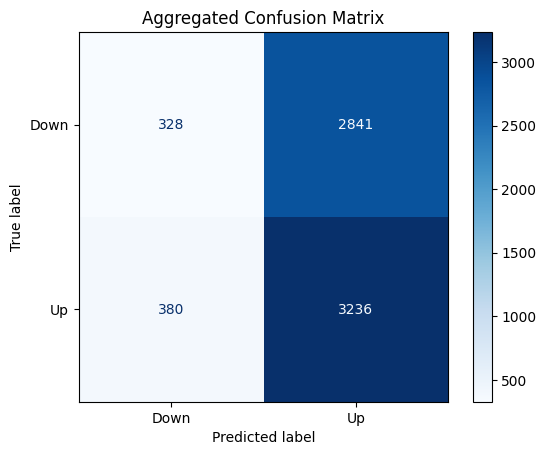

              precision    recall  f1-score      support
0.0            0.463277  0.103503  0.169203  3169.000000
1.0            0.532500  0.894912  0.667698  3616.000000
accuracy       0.525276  0.525276  0.525276     0.525276
macro avg      0.497888  0.499207  0.418451  6785.000000
weighted avg   0.500168  0.525276  0.434871  6785.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching selected economic indicators from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'DGS10': '10-Year Treasury Yield',
    'FEDFUNDS': 'Federal Funds Rate',
    'BAA10Y': 'Baa Corporate Bond Yield Spread',
    'VIXCLS': 'VIX Index',
    'DCOILWTICO': 'Crude Oil Prices',
    'UMCSENT': 'Consumer Confidence Index',
    'RSXFS': 'Retail Sales',
    'HOUST': 'Housing Starts',
    'INDPRO': 'Industrial Production Index'
}

fred_data = {}
for indicator, name in indicators.items():
    fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
    # Convert FRED data index to be timezone-naive
    fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)

# Merge selected FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate selected technical indicators
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
data['RSI_14'] = 100 - (100 / (1 + data['Close'].diff().rolling(window=14).apply(lambda x: (x[x > 0].sum()) / (-x[x < 0].sum()), raw=True)))
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['Bollinger_High'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
data['Bollinger_Low'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Incorporate lagged features
lags = [1, 5, 10]  # Example lag periods
for lag in lags:
    data[f'Close_Lag_{lag}'] = data['Close'].shift(lag)
    data[f'Volume_Lag_{lag}'] = data['Volume'].shift(lag)
    data[f'RSI_Lag_{lag}'] = data['RSI_14'].shift(lag)

# Interaction features
data['Volume_SMA_50'] = data['Volume'] * data['SMA_50']
data['CPI_RSI_Interaction'] = data['CPIAUCSL'] * data['RSI_14']

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the selected FRED series, technical indicators, and engineered features
predictors = ['Close', 'Volume', 'UNRATE', 'CPIAUCSL', 'DGS10',
              'SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'RSI_14',
              'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low'] + new_predictors + [
              'Close_Lag_1', 'Volume_Lag_1', 'RSI_Lag_1',
              'Close_Lag_5', 'Volume_Lag_5', 'RSI_Lag_5',
              'Close_Lag_10', 'Volume_Lag_10', 'RSI_Lag_10',
              'Volume_SMA_50', 'CPI_RSI_Interaction']

# Prepare the dataset
X = data[predictors]
y = data['Target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the deeper neural network model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)

    # Predict
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


# Back to GBC with engineered features

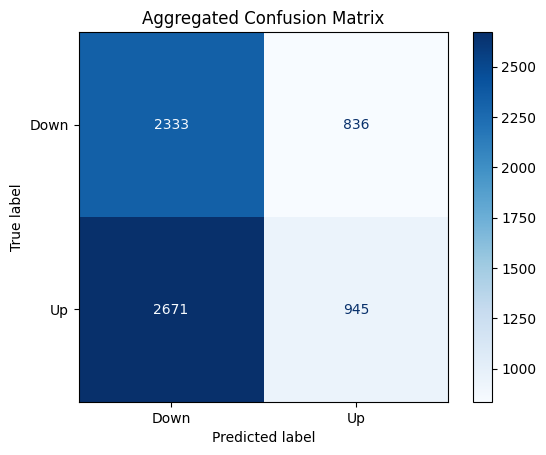

              precision    recall  f1-score      support
0.0            0.466227  0.736194  0.570904  3169.000000
1.0            0.530601  0.261338  0.350195  3616.000000
accuracy       0.483125  0.483125  0.483125     0.483125
macro avg      0.498414  0.498766  0.460549  6785.000000
weighted avg   0.500534  0.483125  0.453279  6785.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching selected economic indicators from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'DGS10': '10-Year Treasury Yield',
    'FEDFUNDS': 'Federal Funds Rate',
    'BAA10Y': 'Baa Corporate Bond Yield Spread',
    'VIXCLS': 'VIX Index',
    'DCOILWTICO': 'Crude Oil Prices',
    'UMCSENT': 'Consumer Confidence Index',
    'RSXFS': 'Retail Sales',
    'HOUST': 'Housing Starts',
    'INDPRO': 'Industrial Production Index'
}

fred_data = {}
for indicator, name in indicators.items():
    fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
    # Convert FRED data index to be timezone-naive
    fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)

# Merge selected FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate selected technical indicators
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
data['RSI_14'] = 100 - (100 / (1 + data['Close'].diff().rolling(window=14).apply(lambda x: (x[x > 0].sum()) / (-x[x < 0].sum()), raw=True)))
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['Bollinger_High'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
data['Bollinger_Low'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Incorporate lagged features
lags = [1, 5, 10]  # Example lag periods
for lag in lags:
    data[f'Close_Lag_{lag}'] = data['Close'].shift(lag)
    data[f'Volume_Lag_{lag}'] = data['Volume'].shift(lag)
    data[f'RSI_Lag_{lag}'] = data['RSI_14'].shift(lag)

# Interaction features
data['Volume_SMA_50'] = data['Volume'] * data['SMA_50']
data['CPI_RSI_Interaction'] = data['CPIAUCSL'] * data['RSI_14']

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the selected FRED series, technical indicators, and engineered features
predictors = ['Close', 'Volume', 'UNRATE', 'CPIAUCSL', 'DGS10',
              'SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'RSI_14',
              'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low'] + new_predictors + [
              'Close_Lag_1', 'Volume_Lag_1', 'RSI_Lag_1',
              'Close_Lag_5', 'Volume_Lag_5', 'RSI_Lag_5',
              'Close_Lag_10', 'Volume_Lag_10', 'RSI_Lag_10',
              'Volume_SMA_50', 'CPI_RSI_Interaction']

# Prepare the dataset
X = data[predictors]
y = data['Target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the Gradient Boosting model
model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


# Notes
- Engineered features don't help
- Deeper neural network helps a bit (62% recall for 'up' class)

# To do
- Try different targets: +1.5% up vs less than that
- Feature importance
- Try explicitly lagged series for next day prediction
  - Used the lagged features (open, close, etc +  macroeconomic indicators) explicitly past the first lag (maybe up to five lags back)

# Greater than +1.5% change or not

## All features

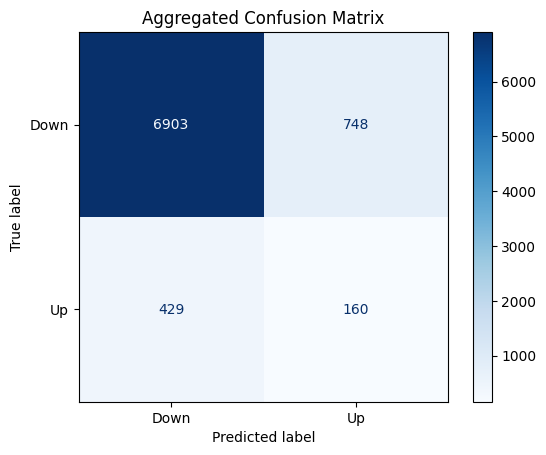

              precision    recall  f1-score     support
0.0            0.941489  0.902235  0.921444  7651.00000
1.0            0.176211  0.271647  0.213761   589.00000
accuracy       0.857160  0.857160  0.857160     0.85716
macro avg      0.558850  0.586941  0.567603  8240.00000
weighted avg   0.886787  0.857160  0.870859  8240.00000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] >= 1.015 * data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic and market data from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims',
    'DGS10': '10-Year Treasury Yield',
    'FEDFUNDS': 'Federal Funds Rate',
    'BAA10Y': 'Baa Corporate Bond Yield Spread',
    'VIXCLS': 'VIX Index',
    'DCOILWTICO': 'Crude Oil Prices',
    'UMCSENT': 'Consumer Confidence Index',
    'RSXFS': 'Retail Sales',
    'HOUST': 'Housing Starts',
    'INDPRO': 'Industrial Production Index'
}

fred_data = {}
for indicator, name in indicators.items():
    try:
        fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
        # Convert FRED data index to be timezone-naive
        fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)
    except Exception as e:
        print(f"Could not fetch data for {name} ({indicator}): {e}")

# Merge available FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Technical indicators
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA_200'] = data['Close'].ewm(span=200, adjust=False).mean()
data['RSI_14'] = 100 - (100 / (1 + data['Close'].diff().rolling(window=14).apply(lambda x: (x[x>0].sum()) / (-x[x<0].sum()), raw=True)))
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['Bollinger_High'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
data['Bollinger_Low'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs, new derived features, and technical indicators
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + new_predictors + [
    'SMA_50', 'SMA_200', 'EMA_50', 'EMA_200', 'RSI_14', 'MACD', 'MACD_Signal', 'Bollinger_High', 'Bollinger_Low'
]

# Prepare the dataset
X = data[predictors]
y = data['Target']

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
model = GradientBoostingClassifier(random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred_proba = model.predict_proba(X_test)

    y_pred = (y_pred_proba[:,1] > 0.95).astype(int)
    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


## Only some features

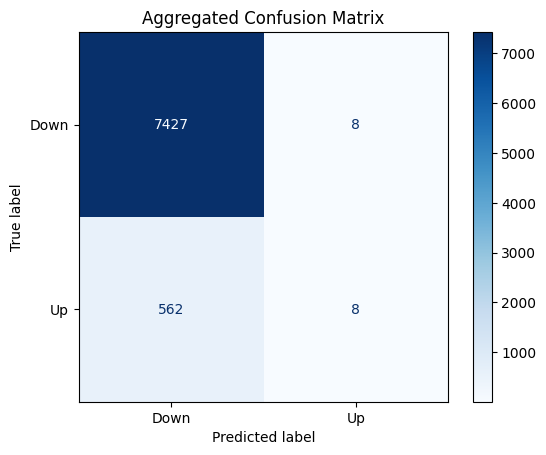

              precision    recall  f1-score      support
0.0            0.929653  0.998924  0.963045  7435.000000
1.0            0.500000  0.014035  0.027304   570.000000
accuracy       0.928795  0.928795  0.928795     0.928795
macro avg      0.714827  0.506480  0.495174  8005.000000
weighted avg   0.899060  0.928795  0.896415  8005.000000


In [ ]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data.drop(labels=['Dividends', 'Stock Splits'], axis=1, inplace=True)
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] >= 1.015 * data['Close']).astype(int)
data = data.loc['1990-01-01':].copy()

# Convert the DatetimeIndex of the S&P 500 data to be timezone-naive
data.index = data.index.tz_localize(None)

# Fetching economic data from FRED
start = datetime(1990, 1, 1)
end = datetime.now()

indicators = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'GDP': 'Gross Domestic Product',
    'ICSA': 'Jobless Claims'
}

fred_data = {}
for indicator, name in indicators.items():
    fred_data[indicator] = web.DataReader(indicator, 'fred', start, end)
    # Convert FRED data index to be timezone-naive
    fred_data[indicator].index = fred_data[indicator].index.tz_localize(None)

# Merge FRED data into the main dataframe
for indicator, df in fred_data.items():
    data = data.merge(df, left_index=True, right_index=True, how='outer')

# Forward fill the missing values that arise due to different frequencies of economic data
data.ffill(inplace=True)

# Incorporate derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['Close'] / rolling_averages['Close']
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data.shift(1).rolling(horizon).sum()['Target']
    new_predictors += [ratio_column, trend_column]

# Drop any remaining NaNs
data.dropna(inplace=True)

# Define the predictors (features) using the original FRED series IDs and new derived features
predictors = ['Close', 'Volume', 'Open', 'High', 'Low'] + list(fred_data.keys()) + new_predictors

# Prepare the dataset
X = data[predictors]
y = data['Target']

# TimeSeriesSplit for backtesting
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the model
model = GradientBoostingClassifier(random_state=42)

# Initialize arrays to collect predictions and actual values for all folds
all_y_true = []
all_y_pred = []

# Perform backtesting and collect predictions
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred_proba = model.predict_proba(X_test)

    y_pred = (y_pred_proba[:,1] > 0.95).astype(int)

    # Collect predictions and actual values
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=['Down', 'Up'], cmap=plt.cm.Blues)
plt.title('Aggregated Confusion Matrix')
plt.show()

# Generate and display a classification report
report = classification_report(all_y_true, all_y_pred, output_dict=True)
print(pd.DataFrame(report).transpose())


# Things to try
- Numerical extrapolation
  - Autoregression SARIMAX etc
  - FB prophet
  - LSTM
- Remove the three important features out see what's most important with what's left
- Try SMOTE with the imbalanced data


# Prophet extrapolation

In [ ]:
!pip install prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4h3kwqvi/jtvob4dz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4h3kwqvi/ycqskzp8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59400', 'data', 'file=/tmp/tmp4h3kwqvi/jtvob4dz.json', 'init=/tmp/tmp4h3kwqvi/ycqskzp8.json', 'output', 'file=/tmp/tmp4h3kwqvi/prophet_model3eu7rn6j/prophet_model-20240814152158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:21:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


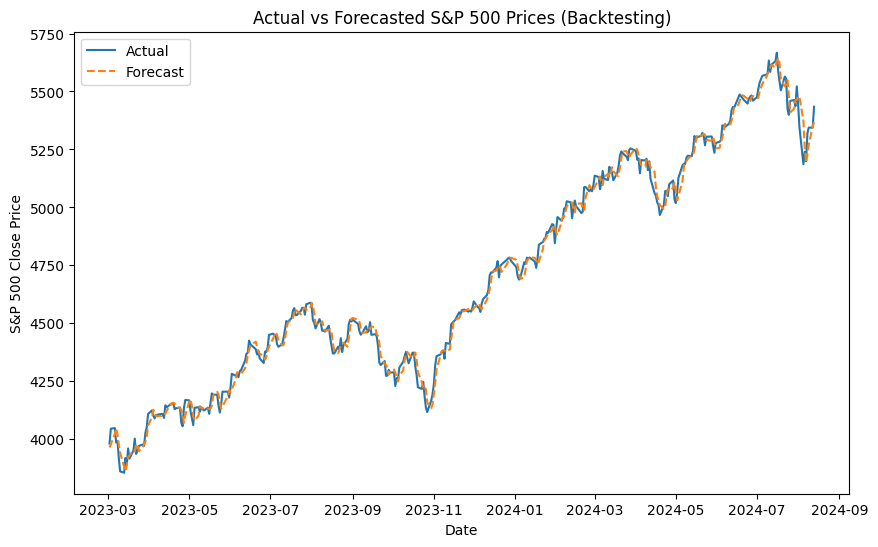

Mean Absolute Error (MAE): 29.17


In [18]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data = data.reset_index()  # Reset index to move Date from index to column
data = data[['Date', 'Close']]  # Use only Date and Close columns
data = data.rename(columns={'Date': 'ds', 'Close': 'y'})  # Rename columns to fit Prophet's expectations

# Convert the 'ds' column to be timezone-naive
data['ds'] = data['ds'].dt.tz_localize(None)

# Define derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    # Apply rolling to the 'y' column only
    rolling_averages = data['y'].rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['y'] / rolling_averages
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data['y'].shift(1).rolling(horizon).sum()
    new_predictors += [ratio_column, trend_column]

# Drop any remaining NaNs due to rolling calculations
data.dropna(inplace=True)

# Set up backtesting
backtest_days = 365  # Set the number of days for backtesting
train_data = data.iloc[:-backtest_days]
test_data = data.iloc[-backtest_days:]

# Create and fit the Prophet model
model = Prophet()

# Add derived feature regressors to the model
for predictor in new_predictors:
    model.add_regressor(predictor)

model.fit(train_data)

# Make predictions on the test set
forecast = model.predict(test_data)

# Ensure the forecast is aligned with the test data
forecast = forecast[['ds', 'yhat']].set_index('ds')
test_data = test_data.set_index('ds')

# Align forecast with test data
results = test_data[['y']].join(forecast)

# Plot the actual vs predicted values on the test set
plt.figure(figsize=(10, 6))
plt.plot(results.index, results['y'], label='Actual')
plt.plot(results.index, results['yhat'], label='Forecast', linestyle='--')
plt.title('Actual vs Forecasted S&P 500 Prices (Backtesting)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

# Evaluate the model performance using metrics such as Mean Absolute Error (MAE)
mae = mean_absolute_error(results['y'], results['yhat'])
print(f'Mean Absolute Error (MAE): {mae:.2f}')


## Plot residuals

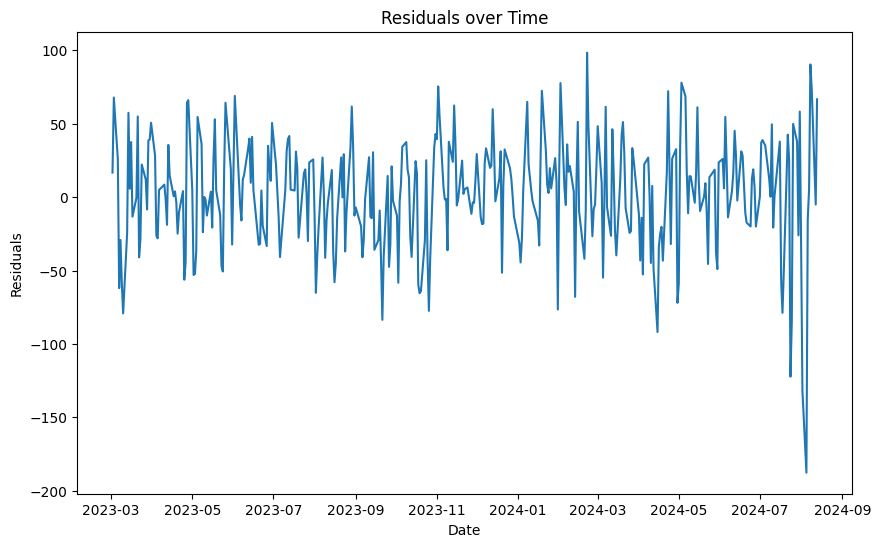

In [19]:
residuals = results['y'] - results['yhat']
plt.figure(figsize=(10, 6))
plt.plot(results.index, residuals)
plt.title('Residuals over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

## Label train and test regions

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4h3kwqvi/lhowvwvg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4h3kwqvi/9hd454nb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82023', 'data', 'file=/tmp/tmp4h3kwqvi/lhowvwvg.json', 'init=/tmp/tmp4h3kwqvi/9hd454nb.json', 'output', 'file=/tmp/tmp4h3kwqvi/prophet_modelhe7lksqn/prophet_model-20240814155852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:58:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:59:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


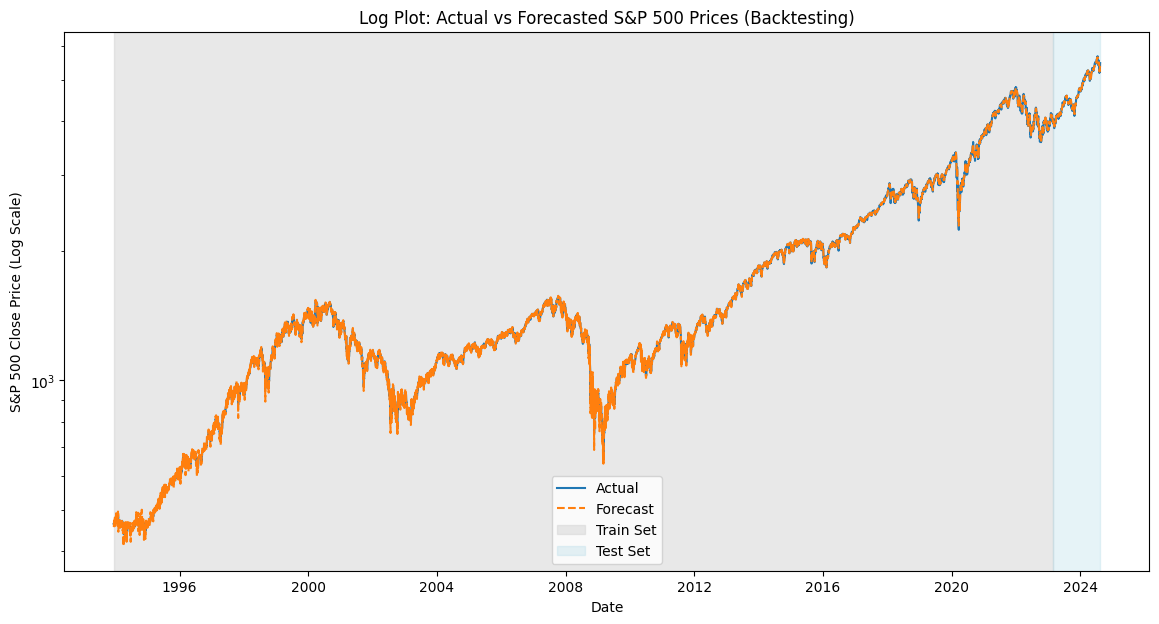

In [32]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data = data.reset_index()  # Reset index to move Date from index to column
data = data[['Date', 'Close']]  # Use only Date and Close columns
data = data.rename(columns={'Date': 'ds', 'Close': 'y'})  # Rename columns to fit Prophet's expectations

# Filter data to start from 1990
data = data[data['ds'] >= '1990-01-01']

# Convert the 'ds' column to be timezone-naive
data['ds'] = data['ds'].dt.tz_localize(None)

# Define derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    # Apply rolling to the 'y' column only
    rolling_averages = data['y'].rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['y'] / rolling_averages
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data['y'].shift(1).rolling(horizon).sum()
    new_predictors += [ratio_column, trend_column]

# Drop any remaining NaNs due to rolling calculations
data.dropna(inplace=True)

# Set up backtesting
backtest_days = 365  # Set the number of days for backtesting
train_data = data.iloc[:-backtest_days].copy()  # Keep ds and y as columns
test_data = data.iloc[-backtest_days:].copy()  # Keep ds and y as columns

# Create and fit the Prophet model
model = Prophet()

# Add derived feature regressors to the model
for predictor in new_predictors:
    model.add_regressor(predictor)

model.fit(train_data)

# Make predictions on the entire dataset to visualize both train and test performance
forecast = model.predict(data)

# Ensure the forecast is aligned with the data
forecast = forecast[['ds', 'yhat']].set_index('ds')
data = data.set_index('ds')

# Align forecast with actual data
results = data[['y']].join(forecast)

# Plot the actual vs predicted values with a logarithmic scale
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['y'], label='Actual')
plt.plot(results.index, results['yhat'], label='Forecast', linestyle='--')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Convert Timestamps to matplotlib date format
train_end_date = train_data['ds'].iloc[-1]
test_start_date = test_data['ds'].iloc[0]
test_end_date = results.index[-1]

# Shade train and test areas
plt.axvspan(results.index[0], train_end_date, color='lightgray', alpha=0.5, label='Train Set')
plt.axvspan(test_start_date, test_end_date, color='lightblue', alpha=0.3, label='Test Set')

plt.title('Log Plot: Actual vs Forecasted S&P 500 Prices (Backtesting)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price (Log Scale)')
plt.legend()
plt.show()

# # Evaluate the model performance on the test set using metrics such as Mean Absolute Error (MAE)
# test_results = results.loc[test_data.index]
# mae = mean_absolute_error(test_results['y'], test_results['yhat'])
# print(f'Mean Absolute Error (MAE) on Test Set: {mae:.2f}')


## Cross validation

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4h3kwqvi/neufac4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4h3kwqvi/_iv6pq8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33402', 'data', 'file=/tmp/tmp4h3kwqvi/neufac4p.json', 'init=/tmp/tmp4h3kwqvi/_iv6pq8y.json', 'output', 'file=/tmp/tmp4h3kwqvi/prophet_modelzhmdmrg7/prophet_model-20240814165343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4h

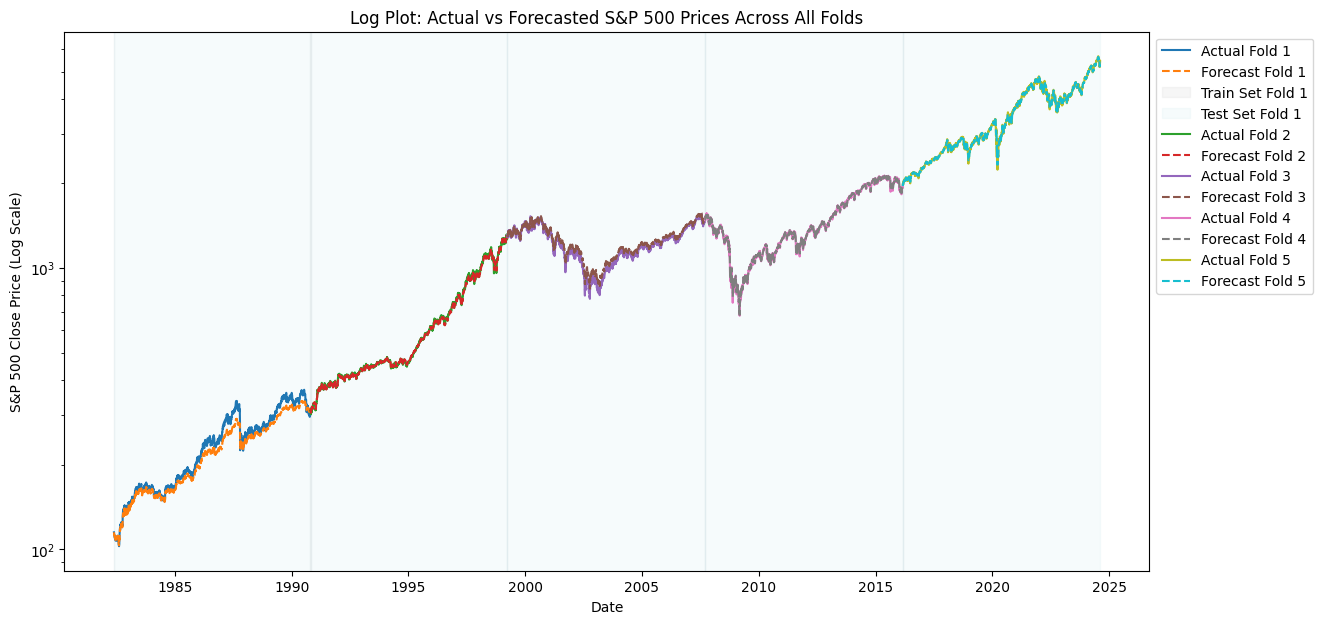

Mean Absolute Error (MAE) for this fold: 12.81
Mean Absolute Error (MAE) for this fold: 5.26
Mean Absolute Error (MAE) for this fold: 29.90
Mean Absolute Error (MAE) for this fold: 8.38
Mean Absolute Error (MAE) for this fold: 23.64
Average MAE across all folds: 16.00


In [34]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Download S&P500 (^GSPC) price history
data = yf.Ticker("^GSPC").history(period="max")

# Basic preprocessing
data = data.reset_index()  # Reset index to move Date from index to column
data = data[['Date', 'Close']]  # Use only Date and Close columns
data = data.rename(columns={'Date': 'ds', 'Close': 'y'})  # Rename columns to fit Prophet's expectations

# Filter data to start from 1970
data = data[data['ds'] >= '1970-01-01']

# Convert the 'ds' column to be timezone-naive
data['ds'] = data['ds'].dt.tz_localize(None)

# Define derived features based on different horizons
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    # Apply rolling to the 'y' column only
    rolling_averages = data['y'].rolling(horizon).mean()
    ratio_column = f'Close_Ratio_{horizon}'
    data[ratio_column] = data['y'] / rolling_averages
    trend_column = f'Trend_{horizon}'
    data[trend_column] = data['y'].shift(1).rolling(horizon).sum()
    new_predictors += [ratio_column, trend_column]

# Drop any remaining NaNs due to rolling calculations
data.dropna(inplace=True)

# Set up cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize a list to store the results
fold_results = []

# Cross-validation loop
for train_index, test_index in tscv.split(data):
    train_data = data.iloc[train_index].copy()
    test_data = data.iloc[test_index].copy()

    # Create and fit the Prophet model
    model = Prophet()

    # Add derived feature regressors to the model
    for predictor in new_predictors:
        model.add_regressor(predictor)

    model.fit(train_data)

    # Make predictions on the test set
    forecast = model.predict(test_data)

    # Ensure the forecast is aligned with the test data
    forecast = forecast[['ds', 'yhat']].set_index('ds')
    test_data = test_data.set_index('ds')

    # Align forecast with actual data
    results = test_data[['y']].join(forecast)

    # Store the results for plotting later
    fold_results.append((results, train_data['ds'].iloc[-1], test_data.index[0]))

# Plot all folds together
plt.figure(figsize=(14, 7))
for i, (results, train_end_date, test_start_date) in enumerate(fold_results):
    plt.plot(results.index, results['y'], label=f'Actual Fold {i+1}')
    plt.plot(results.index, results['yhat'], label=f'Forecast Fold {i+1}', linestyle='--')

    # Shade train and test areas
    plt.axvspan(results.index[0], train_end_date, color='lightgray', alpha=0.2, label=f'Train Set Fold {i+1}' if i == 0 else "")
    plt.axvspan(test_start_date, results.index[-1], color='lightblue', alpha=0.1, label=f'Test Set Fold {i+1}' if i == 0 else "")

# Set y-axis to logarithmic scale
plt.yscale('log')

plt.title('Log Plot: Actual vs Forecasted S&P 500 Prices Across All Folds')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price (Log Scale)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Calculate and print the mean MAE across all folds
mae_scores = []
for results, _, _ in fold_results:
    mae = mean_absolute_error(results['y'], results['yhat'])
    mae_scores.append(mae)
    print(f'Mean Absolute Error (MAE) for this fold: {mae:.2f}')

print(f'Average MAE across all folds: {sum(mae_scores)/len(mae_scores):.2f}')
